In [1]:
import os
import tensorflow as tf
import numpy as np
import PIL
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Concatenate, Activation, UpSampling2D, Conv2D, MaxPooling2D, BatchNormalization

In [2]:
os.listdir(path="../../kaggle")

['lib', 'input', 'working']

In [3]:
MAIN_PATH = "../../kaggle/input/test-ml"

In [4]:
img = PIL.Image.open(MAIN_PATH + '/train/0.jpg')
mask = PIL.Image.open(MAIN_PATH + '/train_mask/0.png')
print(f'Размер основного изображения - {img.size}')
print(f'Размер маски - {mask.size}')

Размер основного изображения - (240, 320)
Размер маски - (240, 320)


In [5]:
train_img_ds = tf.data.Dataset.list_files(MAIN_PATH + '/train/' + '*.jpg', shuffle=False)

2022-03-08 17:52:55.590761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 17:52:55.675344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 17:52:55.676064: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-08 17:52:55.679683: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [18]:
def preprocess_train(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (128, 128))
    img = tf.cast(img, tf.float32) / 255.0
    
    mask_path = tf.strings.regex_replace(file_path,"train", "train_mask")
    mask_path = tf.strings.regex_replace(mask_path,"jpg", "png")
    mask = tf.io.read_file(mask_path)
    mask = tf.io.decode_jpeg(mask, channels=3)
    mask = tf.image.resize(mask, (128, 128))
    mask = tf.cast(mask, tf.float32) / 255.0
    return img, mask 

In [19]:
train_ds = train_img_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(30).prefetch(1)

In [52]:
input_layer = Input(shape=(128, 128, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(input_layer)
conv_1_1 = Activation('relu')(conv_1_1)
conv_1_2 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)
pool_1 = MaxPooling2D(2)(conv_1_2)

conv_2_1 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)
conv_2_2 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)
pool_2 = MaxPooling2D(2)(conv_2_2)

conv_3_1 = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal")(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)
conv_3_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal")(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2)
pool_3 = MaxPooling2D(2)(conv_3_2)

conv_4_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)
conv_4_2 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2)
pool_4 = MaxPooling2D(2)(conv_4_2)

conv_5_1 = Conv2D(512, (3, 3), padding='same', kernel_initializer="he_normal")(pool_4)
conv_5_1 = Activation('relu')(conv_5_1)
conv_5_2 = Conv2D(512, (3, 3), padding='same', kernel_initializer="he_normal")(conv_5_1)
conv_5_2 = Activation('relu')(conv_5_2)
pool_5 = MaxPooling2D(2)(conv_5_2)

conv_6_1 = Conv2D(1024, (3, 3), padding='same', kernel_initializer="he_normal")(pool_5)
conv_6_1 = Activation('relu')(conv_6_1)
conv_6_2 = Conv2D(1024, (3, 3), padding='same', kernel_initializer="he_normal")(conv_6_1)
conv_6_2 = Activation('relu')(conv_6_2)
pool_6 = MaxPooling2D(2)(conv_6_2)

conv_7_1 = Conv2D(2048, (3, 3), padding='same', kernel_initializer="he_normal")(pool_6)
conv_7_1 = Activation('relu')(conv_7_1)
conv_7_2 = Conv2D(2048, (3, 3), padding='same', kernel_initializer="he_normal")(conv_7_1)
conv_7_2 = Activation('relu')(conv_7_2)
pool_7 = MaxPooling2D(2)(conv_7_2)

####
####

up_7 = UpSampling2D(2, interpolation='bilinear')(pool_7)
conc_7 = Concatenate()([conv_7_2, up_7])
conv_up_7_1 = Conv2D(2048, (3, 3), padding='same', kernel_initializer="he_normal")(conc_7)
conv_up_7_1 = Activation('relu')(conv_up_7_1)
conv_up_7_2 = Conv2D(2048, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_7_1)


up_6 = UpSampling2D(2, interpolation='bilinear')(conv_up_7_2)
conc_6 = Concatenate()([conv_6_2, up_6])
conv_up_6_1 = Conv2D(1024, (3, 3), padding='same', kernel_initializer="he_normal")(conc_6)
conv_up_6_1 = Activation('relu')(conv_up_6_1)
conv_up_6_2 = Conv2D(1024, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_6_1)

up_5 = UpSampling2D(2, interpolation='bilinear')(conv_up_6_2)
conc_5 = Concatenate()([conv_5_2, up_5])
conv_up_5_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conc_5)
conv_up_5_1 = Activation('relu')(conv_up_5_1)
conv_up_5_2 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_5_1)

up_4 = UpSampling2D(2, interpolation='bilinear')(conv_up_5_2)
conc_4 = Concatenate()([conv_4_2, up_4])
conv_up_4_1 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conc_4)
conv_up_4_1 = Activation('relu')(conv_up_4_1)
conv_up_4_2 = Conv2D(256, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_4_1)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_4_2)
conc_3 = Concatenate()([conv_3_2, up_3])
conv_up_3_1 = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal")(conc_3)
conv_up_3_1 = Activation('relu')(conv_up_3_1)
conv_up_3_2 = Conv2D(128, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_3_1)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_3_2)
conc_2 = Concatenate()([conv_2_2, up_2])
conv_up_2_1 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(conc_2)
conv_up_2_1 = Activation('relu')(conv_up_2_1)
conv_up_2_2 = Conv2D(64, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_2_1)

up_1 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_1 = Concatenate()([conv_1_2, up_1])
conv_up_1_1 = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal")(conc_1)
conv_up_1_1 = Activation('relu')(conv_up_1_1)
conv_up_1_2 = Conv2D(3, (3, 3), padding='same', kernel_initializer="he_normal")(conv_up_1_1)

output_layer = Activation('sigmoid')(conv_up_1_2)
model = Model(inputs=input_layer, outputs=output_layer)

In [53]:
model.compile(
    keras.optimizers.Adam(learning_rate=0.0001), 
    'binary_crossentropy'
)

In [54]:
callbacks = [
    keras.callbacks.ModelCheckpoint('unet_best.h5', monitor='loss', verbose=0, save_best_only=True, mode='auto'), 
    keras.callbacks.ModelCheckpoint('unet_last.h5', monitor='loss', verbose=0, save_best_only=False, mode='auto')
]

In [61]:
history = model.fit(
    train_ds,
    epochs=600,
    #callbacks=callbacks
)

Epoch 1/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0292
Epoch 2/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0290
Epoch 3/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0290
Epoch 4/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0287
Epoch 5/600
4/4 [==============================] - 1s 252ms/step - loss: 0.0295
Epoch 6/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0293
Epoch 7/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0311
Epoch 8/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0310
Epoch 9/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0338
Epoch 10/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0337
Epoch 11/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0351
Epoch 12/600
4/4 [==============================] - 1s 250ms/step - loss: 0.0362
Epoch 13/600
4/4 [===================

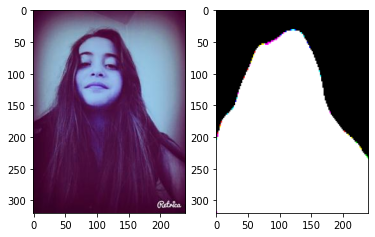

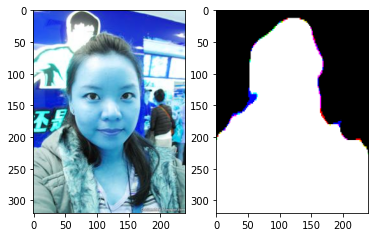

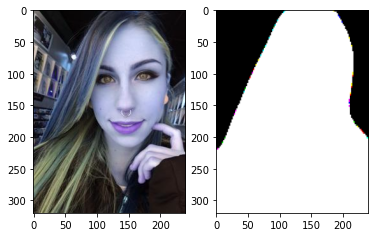

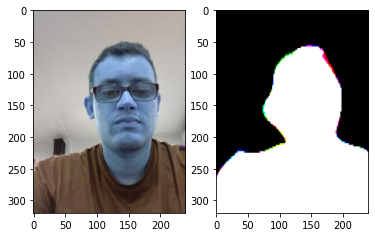

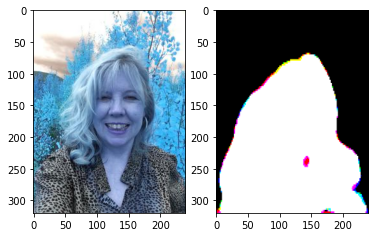

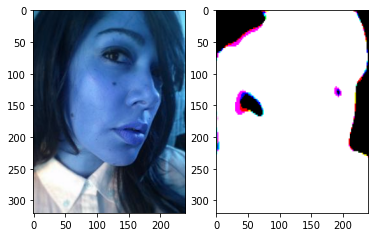

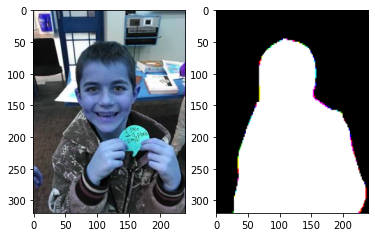

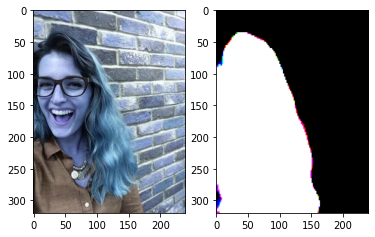

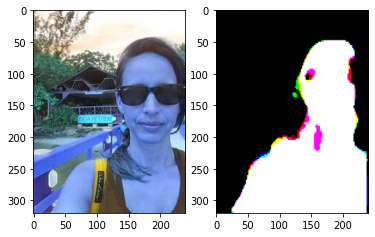

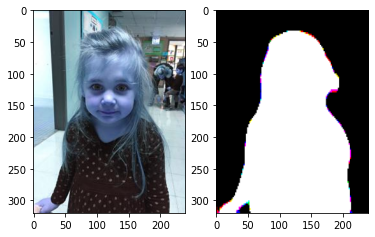

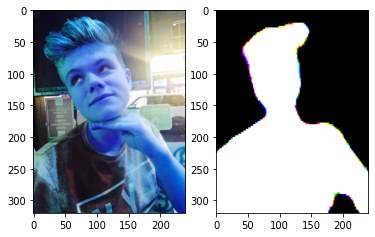

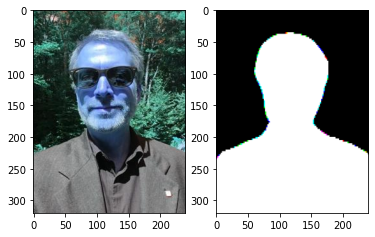

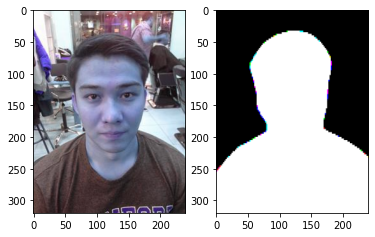

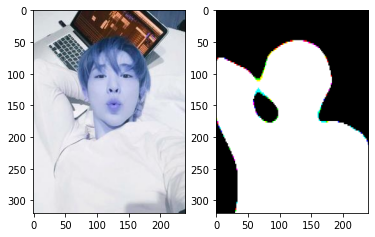

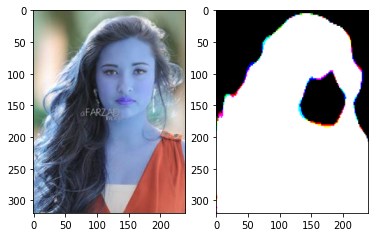

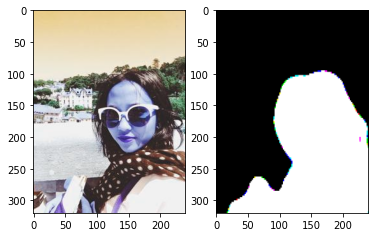

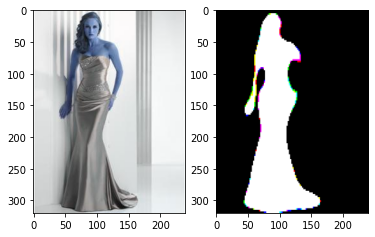

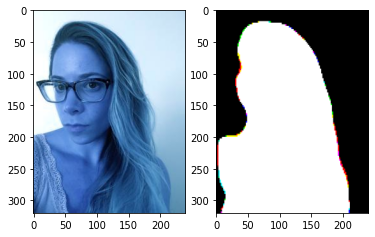

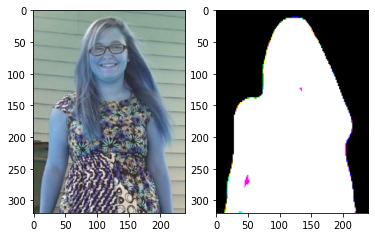

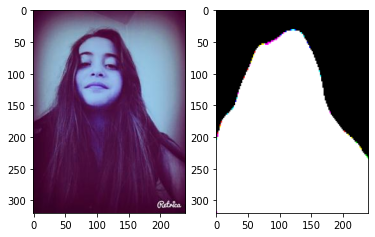

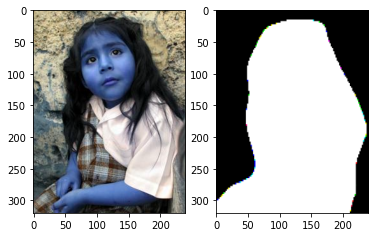

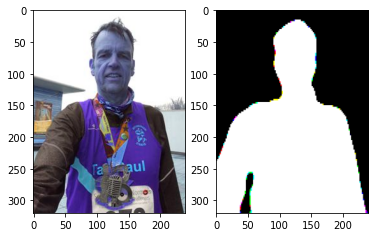

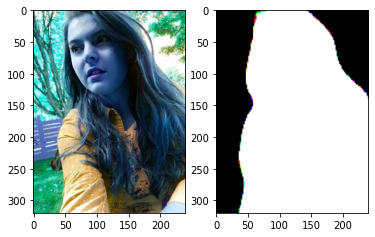

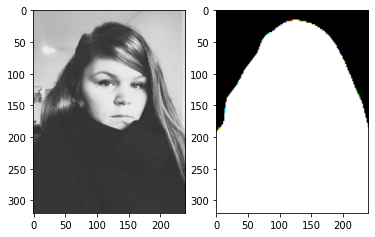

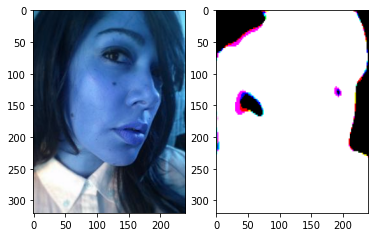

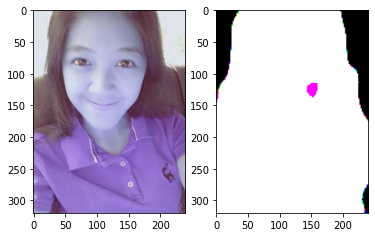

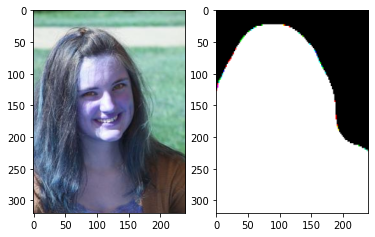

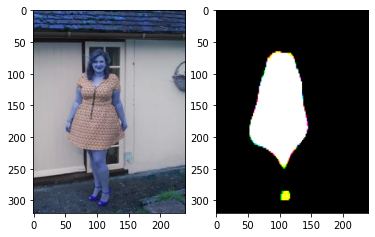

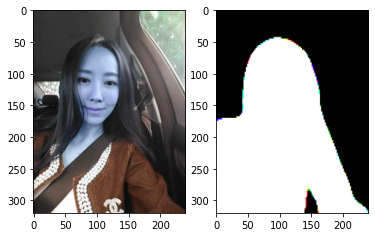

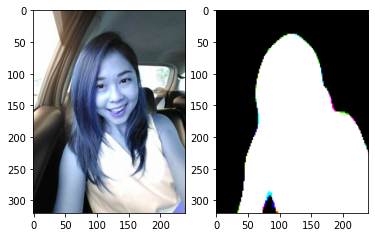

In [64]:
imgs_resizing = []
imgs = []

for i in list(np.random.randint(0, 100, size=30)):
    test_img = cv2.imread(MAIN_PATH + f'/train/{i}.jpg')
    test_img_resizing = cv2.resize(test_img, (128, 128), interpolation = cv2.INTER_AREA)
    imgs.append(test_img)
    imgs_resizing.append(test_img_resizing)
    # test_img_ex = np.expand_dims(test_img, axis=0)

res = model.predict(np.array(imgs_resizing))

for j in range(len(imgs)):
    fig, ax = plt.subplots(1,2)
    img_res = cv2.resize(res[j], (240, 320), interpolation = cv2.INTER_AREA)
    ax[0].imshow(imgs[j])
    ax[1].imshow(img_res)
    plt.show()

[18, 46, 28, 48, 39, 92, 71, 53, 52, 81]